# 4. Evaluation Metrics for Classification

In week 3 we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: Session overview.

Metric Function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('churn_prediction_telco.csv')

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
    'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
    'paymentmethod'
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/Users/Frank/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds.
- Check the accuracy of dummy baselines.

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [11]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


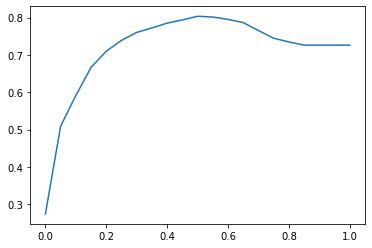

In [12]:
plt.plot(thresholds, scores)

In [13]:
from collections import Counter

In [14]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [15]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [16]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

- Different types of errors and correct decisions.
- Arranging them in a table.

In [17]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [18]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [19]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [20]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [21]:
tp, tn, fp, fn

(210, 922, 101, 176)

In [22]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [23]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [24]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

### Precision

Fraction of positive predictions that are correct.

In [25]:
p = tp / (tp + fp)
p

0.6752411575562701

### Recall

Fraction of correctly identified positive examples

In [26]:
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves

ROC stands for Receiver Operating Characteristic.

### TPR and FPR

In [27]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [28]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [29]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))

In [30]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [31]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

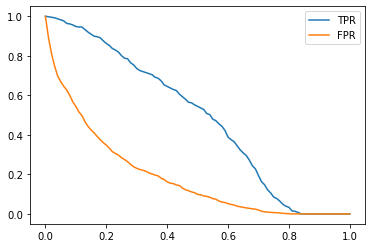

In [32]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

### Random model

In [33]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [34]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [35]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [36]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

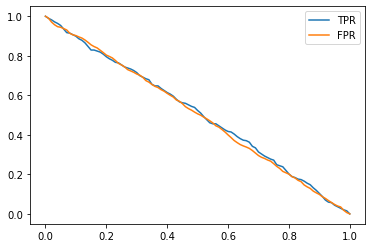

In [37]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

## Ideal model

In [38]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [39]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [41]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [42]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

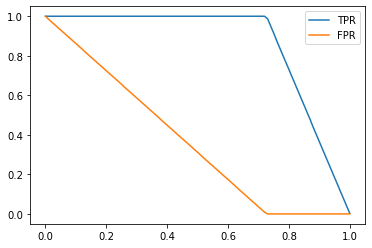

In [43]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

### Putting everything together

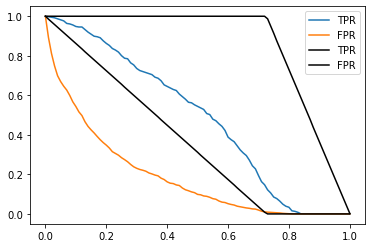

In [44]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

#plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
#plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')

plt.legend()

Text(0.5, 0, 'FPR')

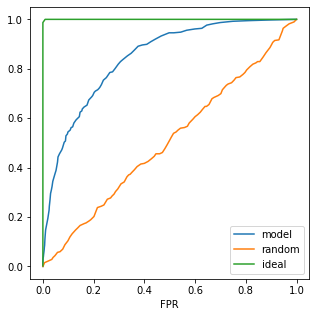

In [45]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr,  label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr,  label='ideal')
plt.legend()
plt.xlabel('FPR')

In [46]:
from sklearn.metrics import roc_curve

In [47]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

Text(0.5, 0, 'FPR')

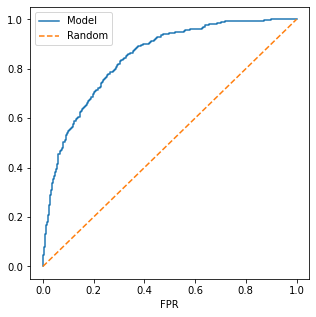

In [48]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')

plt.legend()
plt.xlabel('FPR')

## 4.6 ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

In [49]:
from sklearn.metrics import auc

In [50]:
auc(df_scores.fpr, df_scores.tpr)

0.8438226490207102

In [51]:
auc(fpr, tpr)

0.8438403760148705

In [52]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438403760148705

In [54]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [55]:
import random

In [56]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1
    
success / n

0.84395

In [57]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## 4.7 Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [58]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [59]:
dv, model = train(df_train, y_train)

In [60]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [61]:
y_pred = predict(df_val, dv, model)

In [62]:
from sklearn.model_selection import KFold

In [63]:
from tqdm.auto import tqdm

In [64]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [65]:
scores

[0.843658500208021,
 0.8458337471858032,
 0.8306642584788281,
 0.8319950278186352,
 0.8522285149508958]

In [66]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

- Metric - a single number that describes the performance of a model.
- Accuracy - fraction of correct answers; sometimes misleading.
- Precision and recall are less misleading when we have class inbalance.
- ROC Curve - a way to evaluate the performance at al thresholds; okay using with imbalance.
- K-Fold CV more reliable estimate for performace (mean + std)